<a href="https://colab.research.google.com/github/Anthonyma0706/WSD_medical/blob/main/code_TEAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
root_dir = '/content/drive/'
# Import data storage from google
from google.colab import drive
drive.mount(root_dir)
%cd /content/drive/MyDrive/COMP550_project/Data
%ls

Mounted at /content/drive/
/content/drive/MyDrive/COMP550_project/Data
100w_data.csv                  model_12_20
100w_data_shorten.csv          model_12_20_2
10w_train.csv                  model_12_20_3
1w_data_disambig_for_lesk.csv  pretrain_subset.zip
20w_data_disambig.csv          test.csv
2w_data.csv                    train.csv
3w_test.csv                    train_loss_10w_12_20_84.jpg
70w_data_w_targets.csv         train_loss_10w_12_20.jpg
df_train_100000_sampled.csv    train_loss.jpg
figures/                       valid.csv


# Packages

In [2]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp
#!pip install kaggle
#!pip install transformers

     |████████████████████████████████| 123 kB 5.1 MB/s 
     |████████████████████████████████| 90 kB 8.0 MB/s 
     |████████████████████████████████| 131 kB 25.7 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 8.4 MB 29.1 MB/s 
     |████████████████████████████████| 138 kB 58.4 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
# BERT imports
import numpy as np

from tqdm.auto import tqdm
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import trange
from tqdm.auto import tqdm
import pandas as pd
import io
import matplotlib.pyplot as plt

% matplotlib inline

# Lesk

In [4]:
#Algorithm Reference: http://en.wikipedia.org/wiki/Lesk_algorithm

from nltk.corpus import wordnet 
from nltk.tokenize import WordPunctTokenizer
import sys

functionwords = ['about', 'across', 'against', 'along', 'around', 'at',
                 'behind', 'beside', 'besides', 'by', 'despite', 'down',
                 'during', 'for', 'from', 'in', 'inside', 'into', 'near', 'of',
                 'off', 'on', 'onto', 'over', 'through', 'to', 'toward',
                 'with', 'within', 'without', 'anything', 'everything',
                 'anyone', 'everyone', 'ones', 'such', 'it', 'itself',
                 'something', 'nothing', 'someone', 'the', 'some', 'this',
                 'that', 'every', 'all', 'both', 'one', 'first', 'other',
                 'next', 'many', 'much', 'more', 'most', 'several', 'no', 'a',
                 'an', 'any', 'each', 'no', 'half', 'twice', 'two', 'second',
                 'another', 'last', 'few', 'little', 'less', 'least', 'own',
                 'and', 'but', 'after', 'when', 'as', 'because', 'if', 'what',
                 'where', 'which', 'how', 'than', 'or', 'so', 'before', 'since',
                 'while', 'although', 'though', 'who', 'whose', 'can', 'may',
                 'will', 'shall', 'could', 'be', 'do', 'have', 'might', 'would',
                 'should', 'must', 'here', 'there', 'now', 'then', 'always',
                 'never', 'sometimes', 'usually', 'often', 'therefore',
                 'however', 'besides', 'moreover', 'though', 'otherwise',
                 'else', 'instead', 'anyway', 'incidentally', 'meanwhile']

def overlapcontext(sense_set, sentence, verbose = False):
  #definition = synset.definition()
  definition = sense_set['LABEL'].unique()[0]
  if verbose:
    print('definition:',definition)
  gloss = set(WordPunctTokenizer().tokenize(definition)) # tokenized embedding
  #print('gloss before:',gloss)
  #print(list(sense_set['TEXT']))
  for example in list(sense_set['TEXT']):
    gloss = gloss.union(set(example.split(' ')))
    #print(gloss)
  #print('gloss after:',gloss)
  gloss = gloss.difference( functionwords )
  
  if isinstance(sentence, str):  
    sentence = set(sentence.split(" "))
  elif isinstance(sentence, list):
    sentence = set(sentence)
  elif isinstance(sentence, set):
    pass
  else:
    return
  sentence = sentence.difference( functionwords )
  return len( gloss.intersection(sentence) )

def lesk(df_disambig, target, sentence, verbose=False):
    bestsense = None
    maxoverlap = 0

    df_target =df_disambig[df_disambig['targets']==target]
    senses = df_target['LABEL'].unique()
    for sense in senses:
      #print('sense',sense)
      sense_set = df_target[df_target['LABEL'] == sense]
      overlap = overlapcontext(sense_set,sentence)
      if verbose:
        print('overlap',overlap)
      if overlap > maxoverlap:
        maxoverlap = overlap
        bestsense = sense
    return bestsense

In [5]:
df_disambig = pd.read_csv('70w_data_w_targets.csv') 

In [9]:
#ind_interest = 3046
num_accurate = 0
inds_interest = list(df_disambig[df_disambig['targets']=='GS'].index)[:200]
for ind_interest in tqdm(inds_interest):#[162]:#tqdm(range(df_length100_disambig.shape[0])):
  sentence = df_disambig.iloc[ind_interest,:]['TEXT']
  true_label = df_disambig.iloc[ind_interest,:]['LABEL']
  word = df_disambig.iloc[ind_interest,:]['targets'] #'DHF'#'uPA'

  df_temp = df_disambig.drop(ind_interest)
  pred_sense = lesk(df_temp, word,sentence)

  if true_label == pred_sense:
    num_accurate += 1
accuracy = num_accurate/(len(inds_interest))
print('Accuracy:',accuracy)

  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.905


# Train BERT

In [103]:
!ls

100w_data.csv		       model_12_20_2
100w_data_shorten.csv	       model_12_20_3
10w_train.csv		       pretrain_subset.zip
1w_data_disambig_for_lesk.csv  test_final.csv
20w_data_disambig.csv	       train.csv
2w_data.csv		       train_final.csv
3w_test.csv		       train_loss_10w_12_20_84.jpg
70w_data_w_targets.csv	       train_loss_10w_12_20.jpg
df_train_100000_sampled.csv    train_loss.jpg
figures			       valid.csv
model_12_20


In [108]:
df_train = pd.read_csv('train_final.csv')
df_train

,TEXT,LABEL,targets,label
0,be an attractive therapeutic target in bladder...,electrophysiology,EP,262
1,activity plays a decisive role in fundamental ...,heparanase,HPA,761
2,family practitioners in GA and south dakota we...,georgia,GA,615
3,is unknown which factors determine the severit...,esophageal manometry,EM,365
4,in this paper a new DEP dep method based on ca...,dielectrophoretic,DEP,138
...,...,...,...,...
50916,many EU countries have in recent decades repor...,european,EU,381
50917,maintenance of undifferentiated cells and the ...,dura mater,DM,214
50918,FN paralysis in children may occur as a compli...,facial nerve,FN,426
50919,DD is assuming more importance as it is increa...,diastolic heart failure,DHF,134


In [109]:
print(df_train.shape)
print(df_train['targets'].unique().shape)
print(df_train['label'].unique().shape)

(50921, 4)
(100,)
(415,)


In [55]:
query_data_train = df_train['TEXT']
labels = list(df_train['label']) #must be a list

In [56]:
# add special tokens for BERT to work properly
sentences = np.array(["[CLS] " + query + " [SEP]" for query in query_data_train])
print(sentences[4])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenized_texts = ([tokenizer.tokenize(sent) for sent in sentences])
tokenized_texts = np.array([tokenizer.tokenize(sent) for sent in tqdm(sentences)])

[CLS] to define qualitative and quantitative categories of SE to ETS ets and to assess possible differences for lifestyle factors between exposed and unexposed women we studied nonsmoking women aged selected from a GP sample living in the po delta area near venice north italy information was collected by a standardized questionnaire ets exposure at home at work or elsewhere [SEP]


  0%|          | 0/50921 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [57]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [58]:
# Use train_test_split to split our data into train and validation sets for training
testsize = 0.3

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=testsize)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=testsize)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Load BERT Model: 

In [59]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
nb_labels = len(train_labels)
print('nb_labels:',nb_labels)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=nb_labels)
model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

nb_labels: 35644


'Tesla P100-PCIE-16GB'

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


t_total value of -1 results in schedule not being applied


In [ ]:
# restore training
filepath = 'model_12_20_3'
state = torch.load(filepath)
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.21417886984185106


Epoch:  12%|█▎        | 1/8 [10:50<1:15:53, 650.51s/it]

Validation Accuracy: 0.8585251046025104
Train loss: 0.15507286529874353


Epoch:  25%|██▌       | 2/8 [21:40<1:05:02, 650.39s/it]

Validation Accuracy: 0.8626438284518828
Train loss: 0.1170911591757537


Epoch:  38%|███▊      | 3/8 [32:29<54:07, 649.53s/it]  

Validation Accuracy: 0.8607831107177341
Train loss: 0.09730823411935642


Epoch:  50%|█████     | 4/8 [43:19<43:19, 649.89s/it]

Validation Accuracy: 0.8704890167364017
Train loss: 0.07991179397256118


Epoch:  62%|██████▎   | 5/8 [54:10<32:31, 650.34s/it]

Validation Accuracy: 0.8676828532346316
Train loss: 0.0643580741001564


Epoch:  75%|███████▌  | 6/8 [1:05:01<21:41, 650.54s/it]

Validation Accuracy: 0.8683969665271967
Train loss: 0.05862461151580261


Epoch:  88%|████████▊ | 7/8 [1:15:52<10:50, 650.65s/it]

Validation Accuracy: 0.8693776150627615
Train loss: 0.04899766992048579


Epoch: 100%|██████████| 8/8 [1:26:43<00:00, 650.43s/it]

Validation Accuracy: 0.8680700836820083


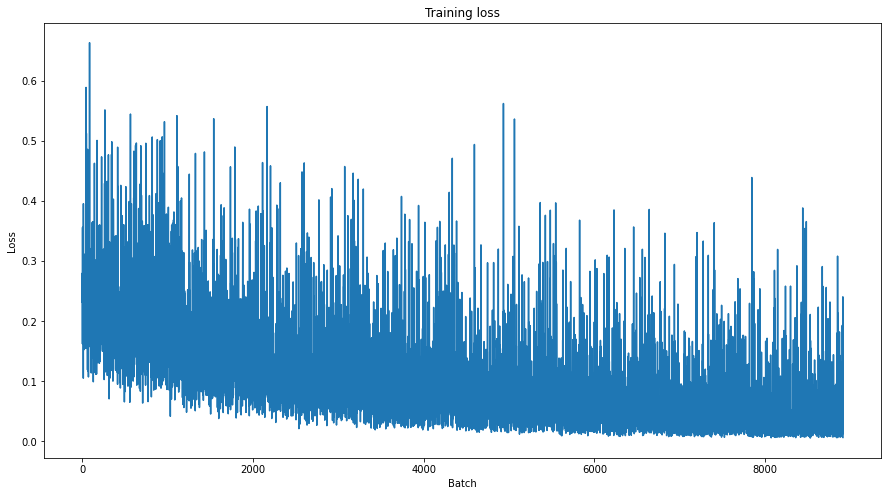

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 8#4

# BERT training loop
for _ in (trange(epochs, desc="Epoch")):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.savefig("train_loss.jpg", dpi=150)
plt.show()

In [ ]:
# Save the current model state
'''
state = {
    'epoch': epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    #...
}
filepath = 'model_12_20_3'
torch.save(state, filepath)
'''

# Test

In [35]:
!ls

100w_data.csv		       model_12_20
100w_data_shorten.csv	       model_12_20_2
10w_train.csv		       model_12_20_3
1w_data_disambig_for_lesk.csv  pretrain_subset.zip
20w_data_disambig.csv	       test.csv
2w_data.csv		       train.csv
3w_test.csv		       train_loss_10w_12_20_84.jpg
70w_data_w_targets.csv	       train_loss_10w_12_20.jpg
df_train_100000_sampled.csv    train_loss.jpg
figures			       valid.csv


In [102]:
df_test = pd.read_csv('test_final.csv')
print(df_test.shape)
df_test = df_test.sample(n = 5000).reset_index(drop=True) #select 2k data as testset
df_test

(12938, 4)


,TEXT,LABEL,targets,label
0,to evaluate the tau and safety of ida haizheng...,acute leukemia,HAL,0
1,studies on the cell immunity in patients with ...,acute leukemia,HAL,0
2,mutant frequencies mfs at the two genetic loci...,acute leukemia,HAL,0
3,nodes and consequently the pathologic developm...,acute leukemia,HAL,0
4,UC blood ucb transplantation is potentially cu...,acute leukemia,HAL,0
...,...,...,...,...
12933,spinocerebellar ataxia type sca is a neurodege...,visual impairment,CVI,1219
12934,CVI limits peoples ability to perform daily ta...,visual impairment,CVI,1219
12935,CVI intracranial pressure viip syndrome is con...,visual impairment,CVI,1219
12936,diabetes whose poor vision could be QTc with a...,visual impairment,CVI,1219


## Pass to BERT

In [74]:
query_data_train = df_test['TEXT']
labels = list(df_test['label'])
# add special tokens for BERT to work properly
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[4])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = np.array([tokenizer.tokenize(sent) for sent in tqdm(sentences)])

print("Tokenize the first sentence:")
print(tokenized_texts[4])

[CLS] a rotavirus reoviruslike agent was associated with diarrheal diseases occurring in to weekold suckling pigs in herds and in weaned pigs in herds transmissible gastroenteritis virus was also detected in of these herds as was EPEC escherichia coli in herds morbidity was generally greater than in pigs of the affected age group within these herds and mortality from diarrhea ranged from to the disease due to RV in suckling pigs appeared similar to the syndrome commonly referred to as milk scours WG scours or week [SEP]


  0%|          | 0/5000 [00:00<?, ?it/s]

Tokenize the first sentence:
['[CLS]', 'a', 'rot', '##avi', '##rus', 're', '##ov', '##irus', '##like', 'agent', 'was', 'associated', 'with', 'dia', '##rr', '##hea', '##l', 'diseases', 'occurring', 'in', 'to', 'week', '##old', 'suck', '##ling', 'pigs', 'in', 'herds', 'and', 'in', 'we', '##ane', '##d', 'pigs', 'in', 'herds', 'trans', '##missible', 'gas', '##tro', '##enter', '##itis', 'virus', 'was', 'also', 'detected', 'in', 'of', 'these', 'herds', 'as', 'was', 'ep', '##ec', 'es', '##cher', '##ichi', '##a', 'coli', 'in', 'herds', 'mor', '##bid', '##ity', 'was', 'generally', 'greater', 'than', 'in', 'pigs', 'of', 'the', 'affected', 'age', 'group', 'within', 'these', 'herds', 'and', 'mortality', 'from', 'dia', '##rr', '##hea', 'ranged', 'from', 'to', 'the', 'disease', 'due', 'to', 'rv', 'in', 'suck', '##ling', 'pigs', 'appeared', 'similar', 'to', 'the', 'syndrome', 'commonly', 'referred', 'to', 'as', 'milk', 'sc', '##ours', 'w', '##g', 'sc', '##ours', 'or', 'week', '[SEP]']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


## Load Model weights

In [67]:
# LOAD MODEL STATES
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
nb_labels = 35644 # This must be the same number as our training
#len(train_labels)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=nb_labels)
model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [68]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

t_total value of -1 results in schedule not being applied


In [69]:
# restore model states
filepath = 'model_12_20_3'#'model'
state = torch.load(filepath)
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

## Report Test Accuracy

### change the validation set, which is our new Test set

In [78]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [86]:
# Use train_test_split to split our data into train and validation sets for training
testsize = 0.01

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=testsize)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=testsize)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Report

In [92]:
## VALIDATION

# Put model in evaluation mode
model.eval()
# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
nb_predictions = 0

for batch in tqdm(train_dataloader):#validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  nb_predictions += len(b_input_ids)
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print('Number of predictions made (Testset size):', nb_predictions)
print('Number of batches:', nb_eval_steps)
print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))

  0%|          | 0/155 [00:00<?, ?it/s]

Number of predictions made (Testset size): 4950
Number of batches: 155
Validation Accuracy: 0.8670454545454547
